In [2]:
import pandas as pd
import os
import konlpy
import re
import ast
data = pd.read_csv('./preprocessing_integrated.csv') # 전처리 된 파일 

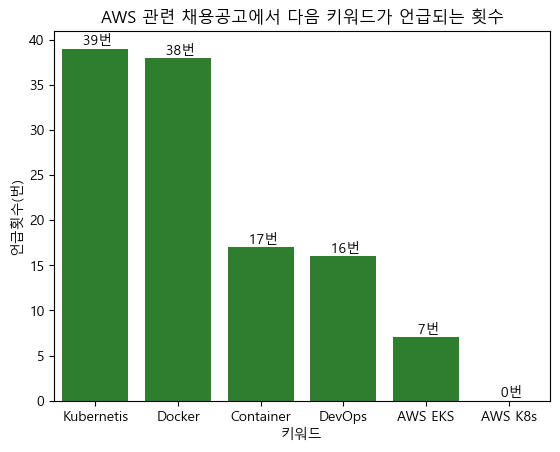

In [3]:
df = data.copy()
df['list'] = df['기술스택'].apply(lambda x: ast.literal_eval(x))

# 'list' column의 value를 합쳐진 리스트로 만든다
flattened_list = [item for sublist in df['list'] for item in sublist]

# 중첩리스트이기 때문에 이를 풀어준다
final_list = [item for sublist in flattened_list for item in (sublist if isinstance(sublist, list) else [sublist])]


# 자바 관련 에러나서 환경변수 설정해주었습니다.
os.environ['JAVA_HOME'] = os.path.expanduser('C:\Program Files\Java\jdk-17')

# 텍스트 마이닝은 KoNLPy의 Kkma 패키지를 이용해주겠습니다.
# 한국어와 영어를 동시에 처리해주는 기능이 없으므로 따로 처리해줄게요.
kkma = konlpy.tag.Kkma()

# '자격요건' 열에서 한글 명사만 뽑아주기
df['자격요건_한글명사'] = df['자격요건'].apply(kkma.nouns)

# '자격요건' 열에서 영어 명사만 뽑아주기
# 이 때, React.js와 Next.js가 . 을 기준으로 나뉘어지기 때문에 처리해주었습니다.
df['자격요건_영어명사'] = df['자격요건'].apply(
    lambda x: re.findall(
        r'\b(?:React\.js|Next\.js|[A-Za-z]+(?:\.js)?)\b', x))

# 위와 같은 방법으로 '우대사항'열도 처리해주겠습니다.
df['우대사항_한글명사'] = df['우대사항'].apply(kkma.nouns)
df['우대사항_영어명사'] = df['우대사항'].apply(
    lambda x: re.findall(
        r'\b(?:React\.js|Next\.js|[A-Za-z]+(?:\.js)?)\b', x))

# column별로 리스트를 합치기
자격_한글_list = [item for sublist in df['자격요건_한글명사'].values for item in sublist]
자격_영어_list = [item for sublist in df['자격요건_영어명사'].values for item in sublist]
우대_한글_list = [item for sublist in df['우대사항_한글명사'].values for item in sublist]
우대_영어_list = [item for sublist in df['우대사항_영어명사'].values for item in sublist]

# 한글명사와 영어명사 리스트를 더해서 하나의 리스트로 만들어줄게요.
자격요건_list = 자격_한글_list + 자격_영어_list
우대사항_list = 우대_한글_list + 우대_영어_list

# 불용어 리스트 가져오기
stp_df = pd.read_csv('./불용어 리스트.csv')
stp_list = stp_df['Stopword'].tolist()

# 불용어 제거
자격요건_list = [i for i in 자격요건_list if i not in stp_list]
우대사항_list = [i for i in 우대사항_list if i not in stp_list]

# 구한 키워드 리스트들을 모두 합치기
a = 자격요건_list + 우대사항_list
b = a + final_list
b.count('Kubernetes')
dic_keyword = {
    'keywords' : ['DevOps','Kubernetis', 'Container', 'Docker', 'AWS EKS', 'AWS K8s'],
    'counts' : [16, 39, 17, 38, 7, 0]
}

df_keyword = pd.DataFrame(dic_keyword)
df_keyword = df_keyword.sort_values(by='counts', ascending=False) #많은 것 순서대로 
import seaborn as sns #그리기 위한 패키지
import matplotlib.pyplot as plt

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
# 막대 그래프 만들기
fig = sns.barplot(data= df_keyword, x = 'keywords', y = 'counts', color= 'forestgreen')

# 각 막대 위에 값 표시
for p in fig.patches:
    fig.annotate(f'{p.get_height() : .0f}번', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    

plt.title('AWS 관련 채용공고에서 다음 키워드가 언급되는 횟수')
plt.ylabel('언급횟수(번)')
plt.xlabel('키워드')
plt.savefig('keyword_barplot.png')
plt.show()
labels = 'DevOps', 'Container', 'Docker', 'AWS EKS', 'Kubernetis'
sizes = [16, 17, 38, 7, 39]

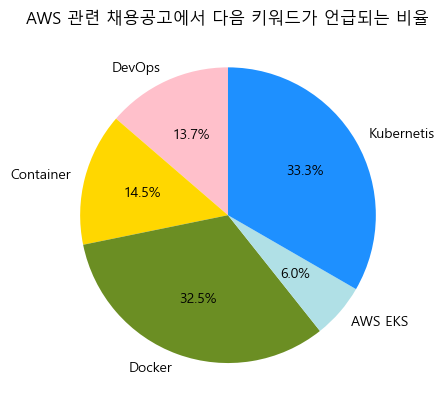

In [4]:
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['pink', 'gold', 'olivedrab', 'powderblue', 'dodgerblue']);
plt.title('AWS 관련 채용공고에서 다음 키워드가 언급되는 비율')
plt.savefig('keyword_piechart.png')
plt.show()

0       미들
1       미들
2      주니어
3       신입
4       신입
      ... 
165     미들
166     미들
167     미들
168     신입
169     신입
Name: 직급, Length: 170, dtype: object


(array([68.,  0.,  0., 70.,  0.,  0., 23.,  0.,  0.,  9.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

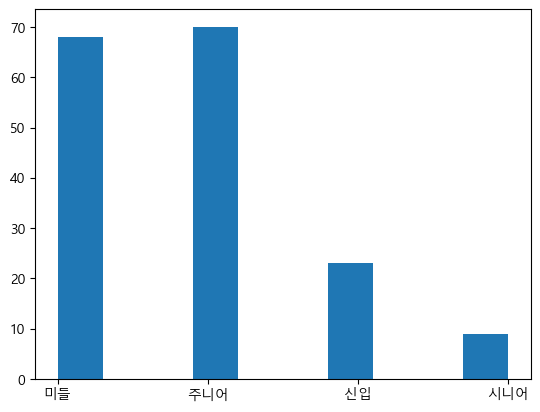

In [5]:
#직급별 분포
print(df['직급'])
plt.hist(data['직급'])

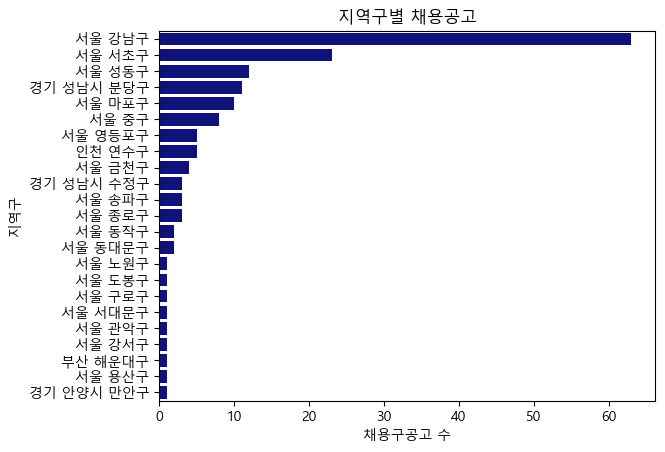

In [6]:
#주소 시각화 (미기재 제외)
address_data = data.loc[data['주소']!='미기재']

address_stat= address_data.groupby('주소').agg(
    주소_빈도=('주소', 'count'),
    매출액_합계=('매출액', 'sum'),
    사원수_합계=('사원수', 'sum'),
    평균연봉_평균=('평균연봉', 'mean')
).reset_index()

address_df = address_stat.sort_values('주소_빈도', ascending=False).reset_index(drop=True)  #채용공고 내림차순


sns.barplot(data=address_df , y='주소', x='주소_빈도' ,color='darkblue')

plt.title('지역구별 채용공고')
plt.xlabel('채용구공고 수')
plt.ylabel('지역구')

plt.savefig("지역구별 채용공고.png",bbox_inches="tight")

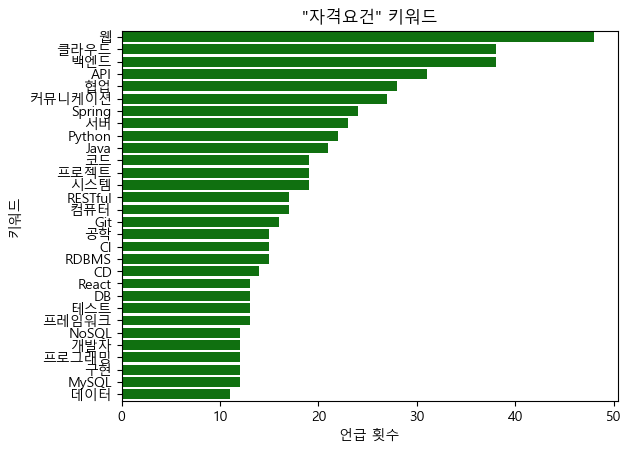

In [7]:
# 막대 그래프 만들기
# '자격요건_list'를 데이터프레임으로 변환
df_자격요건 = pd.DataFrame({'word' : 자격요건_list})

# 단어 빈도 구하기
df_자격요건['count'] = df_자격요건['word'].str.len()
df_자격요건 = df_자격요건.groupby('word', as_index= False)\
    .agg(n = ('word', 'count')).sort_values('n', ascending=False)
top30_자격요건 = df_자격요건.head(30) #상위 30개만 사용

sns.barplot(data = top30_자격요건, y = 'word', x = 'n', color='green')

# x축과 y축의 이름 설정
plt.xlabel('언급 횟수')
plt.ylabel('키워드')

plt.title('"자격요건" 키워드')
plt.savefig('자격요건_barplot.png')

plt.show()

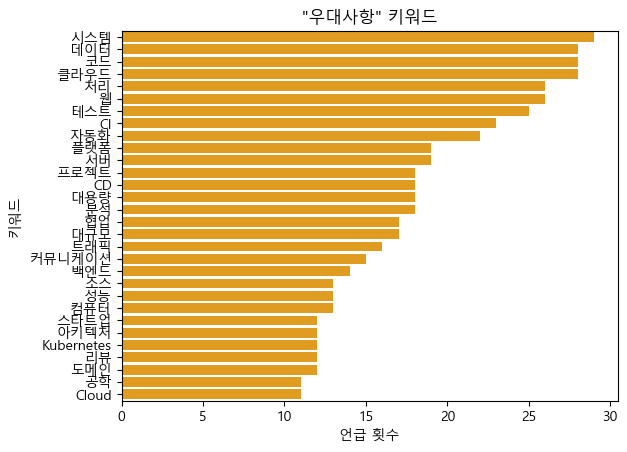

In [8]:
# '우대사항_list'를 데이터프레임으로 변환
df_우대사항 = pd.DataFrame({'word' : 우대사항_list})

# 단어 빈도 구하기
df_우대사항['count'] = df_우대사항['word'].str.len()
df_우대사항 = df_우대사항.groupby('word', as_index= False)\
    .agg(n = ('word', 'count')).sort_values('n', ascending=False)
    
# 단어 빈도 상위 30개 추출
top30_우대사항 = df_우대사항.head(30)
# 막대 그래프 만들기
sns.barplot(data = top30_우대사항, y = 'word', x = 'n', color='orange')

# x축과 y축의 이름 설정
plt.xlabel('언급 횟수')
plt.ylabel('키워드')

plt.title('"우대사항" 키워드')
plt.savefig('우대사항_barplot.png')

plt.show()

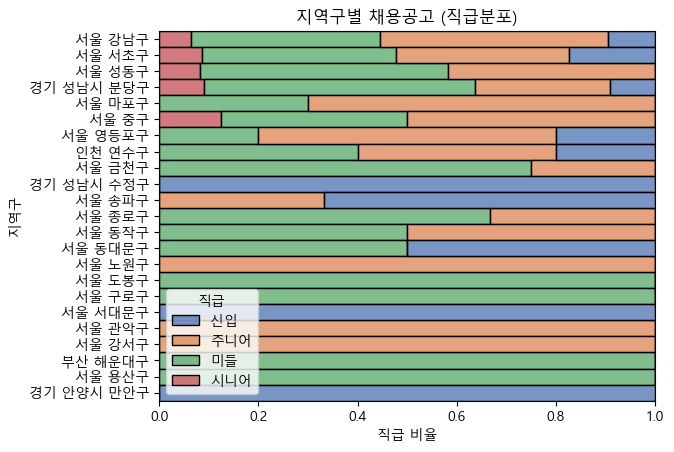

In [18]:
address_data['주소2'] = pd.Categorical(address_data['주소'], address_df['주소'])

sns.histplot(data=address_data, y='주소2', hue ='직급', multiple='fill', hue_order=['신입','주니어','미들','시니어'])

plt.title('지역구별 채용공고 (직급분포)')
plt.xlabel('직급 비율')
plt.ylabel('지역구')

#plt.show()
plt.savefig("지역구별 채용공고_직급분포.png",bbox_inches="tight") #지역별 채용 공고 분포 확인

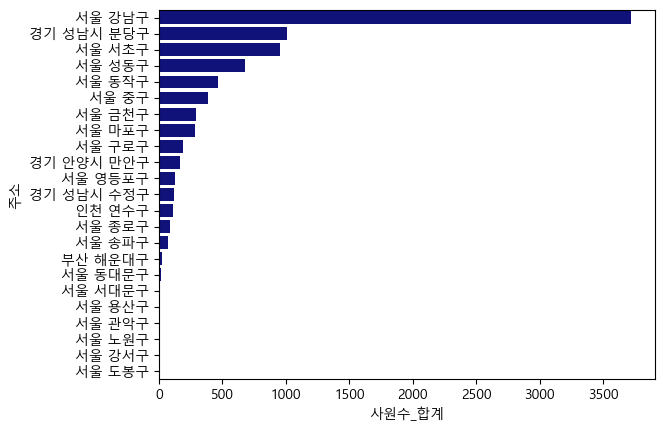

In [10]:
staff_df = address_stat.sort_values('사원수_합계', ascending=False)  #사원수 내림차순
sns.barplot(data=staff_df, y='주소', x='사원수_합계',color='darkblue')
plt.show() #지역 별 기업의 사원 숫자 분포 확인

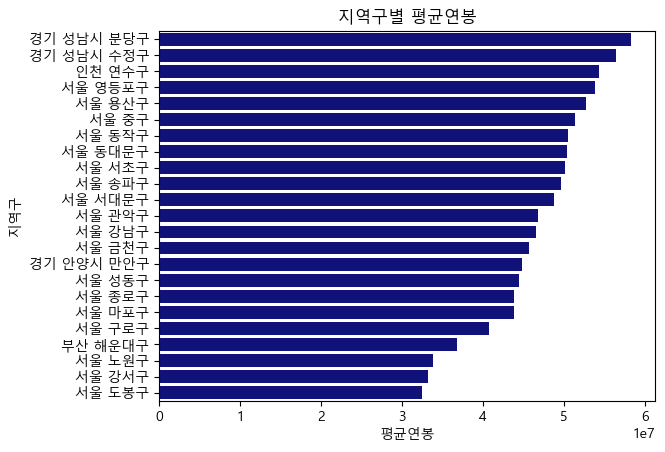

In [11]:
wage_df = address_stat.sort_values('평균연봉_평균', ascending=False)  # 평균연봉 내림차순
sns.barplot(data=wage_df, y='주소', x='평균연봉_평균',color='darkblue')

plt.title('지역구별 평균연봉')
plt.xlabel('평균연봉')
plt.ylabel('지역구')
#plt.xticks([20000000,40000000,60000000],['2','4','6'])


#plt.show()
plt.savefig("지역구별 평균연봉.png",bbox_inches="tight")

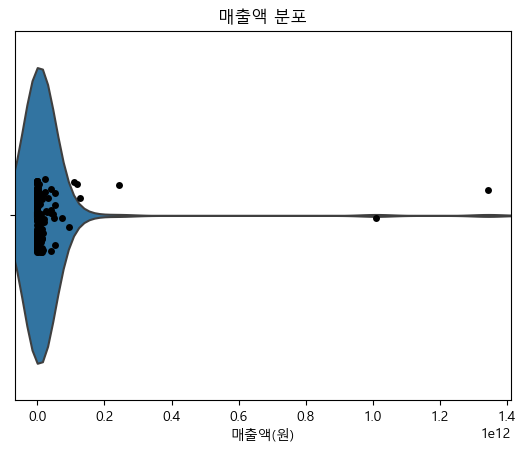

In [12]:
sns.violinplot(data=df, x='매출액')
sns.stripplot(data=df, x='매출액', color='black') #기업들의 매출액 분포 확인

plt.title('매출액 분포')  # 그래프 제목
plt.xlabel('매출액(원)')  # x축 라벨
plt.ylabel('')  # y축 라벨
plt.show()  # 그래프 보여주기

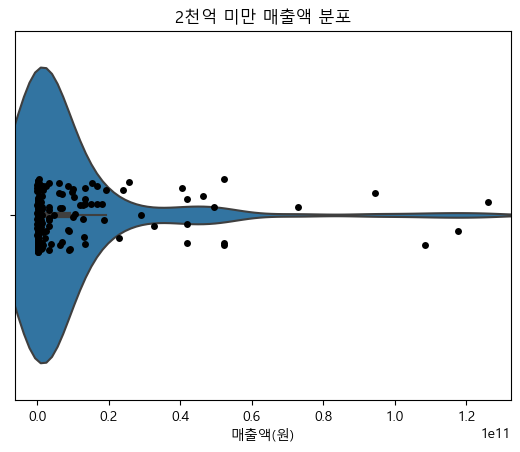

In [13]:
df2 = df.query('매출액 < 200000000000') #2000억 미만 기업들의 매출액 분포 확인
sns.violinplot(data=df2, x='매출액')
sns.stripplot(data=df2, x='매출액', color='black')

plt.title('2천억 미만 매출액 분포')  # 그래프 제목
plt.xlabel('매출액(원)')  # x축 라벨
plt.ylabel('')  # y축 라벨
plt.show()  # 그래프 보여주기

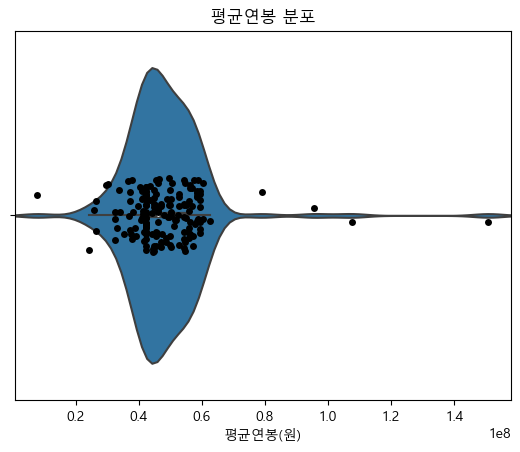

In [14]:
sns.violinplot(data=df, x='평균연봉') #평균연봉 분포 확인
sns.stripplot(data=df, x='평균연봉', color='black')

plt.title('평균연봉 분포')  # 그래프 제목
plt.xlabel('평균연봉(원)')  # x축 라벨
plt.ylabel('')  # y축 라벨
plt.show()  # 그래프 보여주기

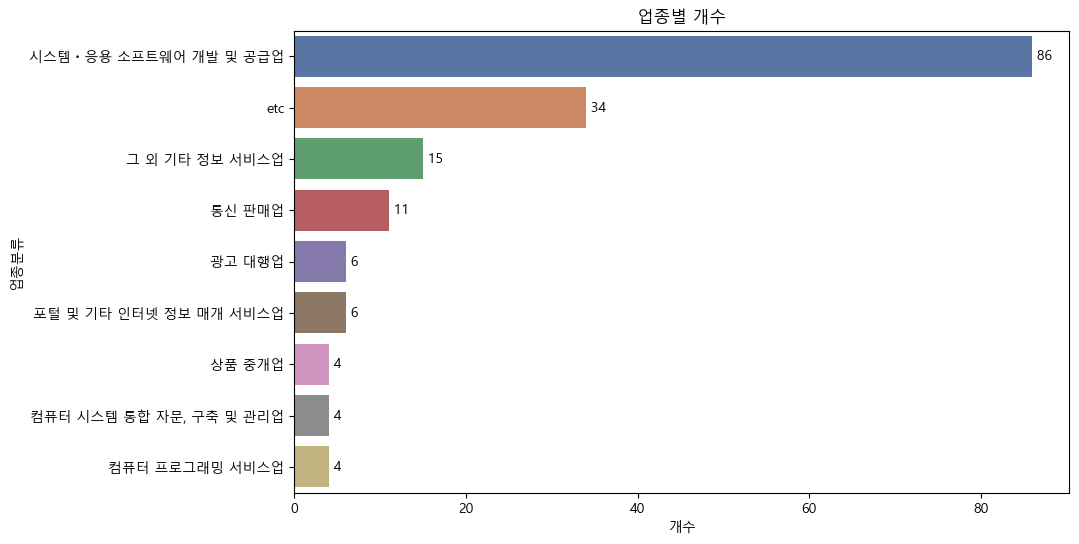

In [15]:
counts = df['업종분류'].value_counts()

# 4개 미만인 업종을 'etc'로 묶음
counts.index = counts.index.where(counts >= 4, 'etc')   # 조건을 만족하지 않을 경우 인덱스 값이 'etc'로 변경

# 다시 집계하여 'etc' 포함된 새로운 개수 계산
new_counts = counts.groupby(by=counts.index).sum().sort_values(ascending=False)

data = new_counts.reset_index()
data.columns = ['업종분류', 'count']  # 열 이름 설정

# 시각화
plt.figure(figsize=(10, 6))  # 그래프의 크기 설정
# 가로 막대 그래프 생성
ax = sns.barplot(x='count', y='업종분류', data=data, palette='deep')
# 각 막대에 대해 값을 표시
for i, (value, name) in enumerate(zip(data['count'], data['업종분류'])):
    ax.text(value, i, f' {value}', ha='left', va='center')

plt.title('업종별 개수')  # 그래프 제목
plt.xlabel('개수')  # x축 라벨
plt.ylabel('업종분류')  # y축 라벨
plt.show()  # 그래프 보여주기

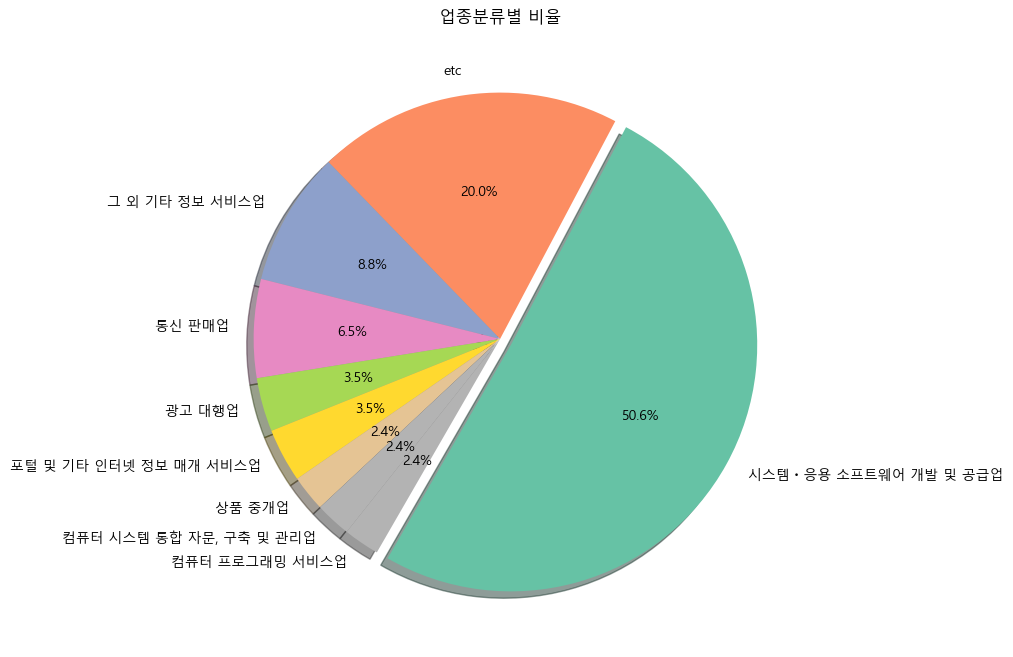

In [16]:
plt.figure(figsize=(10, 8))
explode = (0.05, 0, 0, 0, 0, 0, 0, 0, 0)   
new_counts.plot(kind='pie', autopct='%1.1f%%', startangle=240, colormap='Set2', explode=explode, shadow=True)
plt.title('업종분류별 비율')
plt.ylabel('')  # y축 레이블 제거
plt.show()

C:\Users\BIG3-09\AppData\Local\Temp\ipykernel_20376\3968958003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['업종'] = df_new['업종분류'].apply(lambda x: 'etc' if counts[x] < 4 else x)


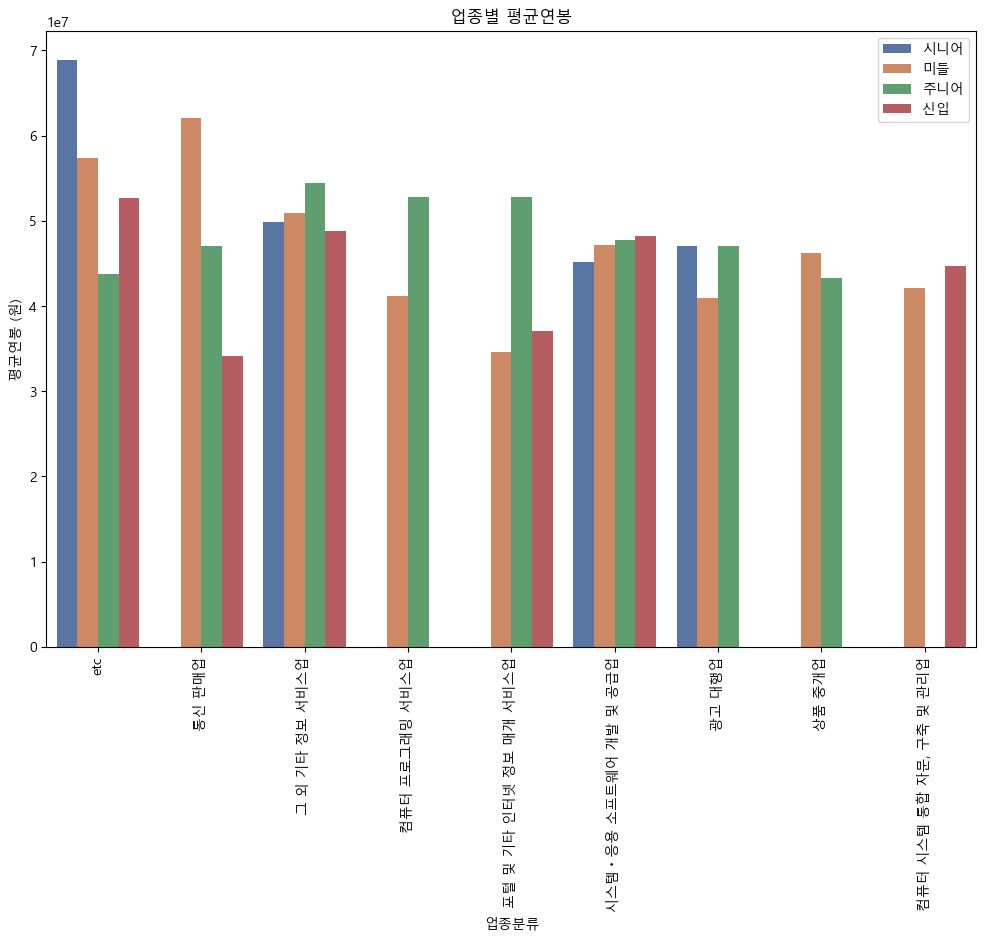

In [17]:
# IT 관련 업종 리스트
it_list = ['시스템ㆍ응용 소프트웨어 개발 및 공급업', '그 외 기타 정보 서비스업', 
           '컴퓨터 시스템 통합 자문, 구축 및 관리업', '컴퓨터 프로그래밍 서비스업', 
           '포털 및 기타 인터넷 정보 매개 서비스업', '기타 정보 기술 및 컴퓨터 운영 관련 서비스업', 
           '자료 처리, 호스팅 및 관련 서비스업']

# it_list에 있는 업종들 데이터프레임으로 저장
df_system = df[df['업종분류'].isin(it_list)]

# 그 외 업종 리스트
etc_list = [i for i in df['업종분류'] if i not in it_list]

# etc_list에 있는 업종들 데이터프레임으로 저장
df_etc = df[df['업종분류'].isin(etc_list)]

# csv로 저장
df_new = df[['업종분류', '직급', '매출액', '평균연봉']]

counts = df_new['업종분류'].value_counts()
# 4개 미만인 업종을 'etc'로 변경
df_new['업종'] = df_new['업종분류'].apply(lambda x: 'etc' if counts[x] < 4 else x)
# 업종 별 매출액과 평균연봉의 평균 계산
df_new_mean = df_new.groupby(['업종','직급'])[['매출액', '평균연봉']].mean()

df_new_mean = df_new_mean.reset_index()   # 인덱스 재설정
df_new_mean = pd.DataFrame(df_new_mean)

plt.figure(figsize=(12, 8))
sns.set_palette('deep')
sns.barplot(x='업종', y='평균연봉', data=df_new_mean.sort_values(by='평균연봉', ascending=False),hue='직급')
plt.xlabel('업종분류')
plt.ylabel('평균연봉 (원)')
plt.xticks(rotation=90)
plt.title('업종별 평균연봉')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
plt.show()